In [1]:
import collections
import bert.modeling as modeling
import bert.tokenization as tokenization
import tensorflow as tf
import easydict 
tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
from enum import Enum
class PoolingStrategy(Enum):
    NONE = 0
    REDUCE_MAX = 1
    REDUCE_MEAN = 2
    REDUCE_MEAN_MAX = 3
    FIRST_TOKEN = 4  # corresponds to [CLS] for single sequences
    LAST_TOKEN = 5  # corresponds to [SEP] for single sequences
    CLS_TOKEN = 4  # corresponds to the first token for single seq.
    SEP_TOKEN = 5  # corresponds to the last token for single seq.

    def __str__(self):
        return self.name

    @staticmethod
    def from_string(s):
        try:
            return PoolingStrategy[s]
        except KeyError:
            raise ValueError()

In [3]:
_models_path = '/Users/sasha/dev/mmuze/_models/BERT'
BERT_BASE_DIR=f'{_models_path}/uncased_L-24_H-1024_A-16/'
# bert_config_path=BERT_BASE_DIR + "bert_config.json"
# vocab_file= 
# init_checkpoint=BERT_BASE_DIR+"bert_model.ckpt"

args = easydict.EasyDict({
    "model_dir": BERT_BASE_DIR,
    'tuned_model_dir': None,
    'ckpt_name': 'bert_model.ckpt',
    'config_name': 'bert_config.json',
    'max_seq_len': 128,
    'xla': False,
    'pooling_strategy': PoolingStrategy.REDUCE_MAX,
    'pooling_layer': [-3,4],
    'do_lower_case': True,
    'vocab_file': BERT_BASE_DIR+"vocab.txt"
})

In [4]:
class InputExample(object):
    def __init__(self, unique_id, text_a, text_b):
        self.unique_id = unique_id
        self.text_a = text_a
        self.text_b = text_b

    def __str__(self):
        return f"unique_id:{self.unique_id}; text_a:{self.text_a}; text_b:{self.text_b}"
    __repr__ = __str__

class InputFeatures(object):
    """A single set of features of data."""
    def __init__(self, unique_id, tokens, input_ids, input_mask, input_type_ids):
        self.unique_id = unique_id
        self.tokens = tokens
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.input_type_ids = input_type_ids
        
    def __str__(self):
        return f"unique_id:{self.unique_id}; \
                 tokens:{self.tokens}; \
                 input_type_ids:{self.input_type_ids} \
                 input_ids:{self.input_ids} \
                 input_mask:{self.input_mask}"
    __repr__ = __str__
    
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
          break
        if len(tokens_a) > len(tokens_b):
          tokens_a.pop()
        else:
          tokens_b.pop()
    
def convert_examples_to_features(examples, seq_length, tokenizer):
  """Loads a data file into a list of `InputBatch`s."""

  features = []
  for (ex_index, example) in enumerate(examples):
    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = None
    if example.text_b:
      tokens_b = tokenizer.tokenize(example.text_b)

    if tokens_b:
      # Modifies `tokens_a` and `tokens_b` in place so that the total
      # length is less than the specified length.
      # Account for [CLS], [SEP], [SEP] with "- 3"
      _truncate_seq_pair(tokens_a, tokens_b, seq_length - 3)
    else:
      # Account for [CLS] and [SEP] with "- 2"
      if len(tokens_a) > seq_length - 2:
        tokens_a = tokens_a[0:(seq_length - 2)]

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0     0   0   0  0     0 0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). This is not *strictly* necessary
    # since the [SEP] token unambiguously separates the sequences, but it makes
    # it easier for the model to learn the concept of sequences.
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as as the "sentence vector". Note that this only makes sense because
    # the entire model is fine-tuned.
    tokens = []
    input_type_ids = []
    tokens.append("[CLS]")
    input_type_ids.append(0)
    for token in tokens_a:
      tokens.append(token)
      input_type_ids.append(0)
    tokens.append("[SEP]")
    input_type_ids.append(0)

    if tokens_b:
      for token in tokens_b:
        tokens.append(token)
        input_type_ids.append(1)
      tokens.append("[SEP]")
      input_type_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < seq_length:
      input_ids.append(0)
      input_mask.append(0)
      input_type_ids.append(0)

    assert len(input_ids) == seq_length
    assert len(input_mask) == seq_length
    assert len(input_type_ids) == seq_length

    if ex_index < 1:
      tf.logging.info("*** Example ***")
      tf.logging.info("unique_id: %s" % (example.unique_id))
      tf.logging.info("tokens: %s" % " ".join(
          [tokenization.printable_text(x) for x in tokens]))
      tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
      tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
      tf.logging.info(
          "input_type_ids: %s" % " ".join([str(x) for x in input_type_ids]))

    features.append(
        InputFeatures(
            unique_id=example.unique_id,
            tokens=tokens,
            input_ids=input_ids,
            input_mask=input_mask,
            input_type_ids=input_type_ids))
  return features

In [5]:
from termcolor import colored
import logging
import os
import json
import contextlib
import tempfile
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

class BertEstimator():
    
    def __init__(self, args):
        self.args = args        
        self.logger = logger#logging.getLogger()
        self.graph_path = self.optimize_graph(args, self.logger)
    
    def optimize_graph(self, args, logger):        
        try:
            # we don't need GPU for optimizing the graph        
            from tensorflow.python.tools.optimize_for_inference_lib import optimize_for_inference

            config = tf.ConfigProto(device_count={'GPU': 0}, allow_soft_placement=True)

            config_fp = os.path.join(args.model_dir, args.config_name)
            init_checkpoint = os.path.join(args.tuned_model_dir or args.model_dir, args.ckpt_name)            
            logger.info('model config: %s' % config_fp)
            logger.info(
                'checkpoint%s: %s' % (' (override by fine-tuned model)' if args.tuned_model_dir else '', init_checkpoint))
            with tf.gfile.GFile(config_fp, 'r') as f:
                bert_config = modeling.BertConfig.from_dict(json.load(f))

            logger.info('build graph...')
            # input placeholders, not sure if they are friendly to XLA
            input_ids = tf.placeholder(tf.int32, (None, args.max_seq_len), 'input_ids')
            input_mask = tf.placeholder(tf.int32, (None, args.max_seq_len), 'input_mask')
            input_type_ids = tf.placeholder(tf.int32, (None, args.max_seq_len), 'input_type_ids')

            jit_scope = tf.contrib.compiler.jit.experimental_jit_scope if args.xla else contextlib.suppress

            with jit_scope():
                input_tensors = [input_ids, input_mask, input_type_ids]

                model = modeling.BertModel(
                    config=bert_config,
                    is_training=False,
                    input_ids=input_ids,
                    input_mask=input_mask,
                    token_type_ids=input_type_ids,
                    use_one_hot_embeddings=False)

                tvars = tf.trainable_variables()

                (assignment_map, initialized_variable_names
                 ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)

                tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

                minus_mask = lambda x, m: x - tf.expand_dims(1.0 - m, axis=-1) * 1e30
                mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
                masked_reduce_max = lambda x, m: tf.reduce_max(minus_mask(x, m), axis=1)
                masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                        tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)

                with tf.variable_scope("pooling"):
                    if len(args.pooling_layer) == 1:
                        encoder_layer = model.all_encoder_layers[args.pooling_layer[0]]
                    else:
                        all_layers = [model.all_encoder_layers[l] for l in args.pooling_layer]
                        encoder_layer = tf.concat(all_layers, -1)

                    input_mask = tf.cast(input_mask, tf.float32)
                    if args.pooling_strategy == PoolingStrategy.REDUCE_MEAN:
                        pooled = masked_reduce_mean(encoder_layer, input_mask)
                    elif args.pooling_strategy == PoolingStrategy.REDUCE_MAX:
                        pooled = masked_reduce_max(encoder_layer, input_mask)
                    elif args.pooling_strategy == PoolingStrategy.REDUCE_MEAN_MAX:
                        pooled = tf.concat([masked_reduce_mean(encoder_layer, input_mask),
                                            masked_reduce_max(encoder_layer, input_mask)], axis=1)
                    elif args.pooling_strategy == PoolingStrategy.FIRST_TOKEN or \
                            args.pooling_strategy == PoolingStrategy.CLS_TOKEN:
                        pooled = tf.squeeze(encoder_layer[:, 0:1, :], axis=1)
                    elif args.pooling_strategy == PoolingStrategy.LAST_TOKEN or \
                            args.pooling_strategy == PoolingStrategy.SEP_TOKEN:
                        seq_len = tf.cast(tf.reduce_sum(input_mask, axis=1), tf.int32)
                        rng = tf.range(0, tf.shape(seq_len)[0])
                        indexes = tf.stack([rng, seq_len - 1], 1)
                        pooled = tf.gather_nd(encoder_layer, indexes)
                    elif args.pooling_strategy == PoolingStrategy.NONE:
                        pooled = mul_mask(encoder_layer, input_mask)
                    else:
                        raise NotImplementedError()

                pooled = tf.identity(pooled, 'final_encodes')

                output_tensors = [pooled]
                tmp_g = tf.get_default_graph().as_graph_def()

            with tf.Session(config=config) as sess:
                logger.info('load parameters from checkpoint...')
                sess.run(tf.global_variables_initializer())
                logger.info('freeze...')
                tmp_g = tf.graph_util.convert_variables_to_constants(sess, tmp_g, [n.name[:-2] for n in output_tensors])
                dtypes = [n.dtype for n in input_tensors]
                logger.info('optimize...')
                tmp_g = optimize_for_inference(
                    tmp_g,
                    [n.name[:-2] for n in input_tensors],
                    [n.name[:-2] for n in output_tensors],
                    [dtype.as_datatype_enum for dtype in dtypes],
                    False)
            tmp_file = tempfile.NamedTemporaryFile('w', delete=False).name
            logger.info('write graph to a tmp file: %s' % tmp_file)
            with tf.gfile.GFile(tmp_file, 'wb') as f:
                f.write(tmp_g.SerializeToString())
            return tmp_file
        except Exception as e:
            logger.error('fail to optimize the graph!')
            logger.error(e)


    def get_estimator(self):
        from tensorflow.python.estimator.estimator import Estimator
        from tensorflow.python.estimator.run_config import RunConfig
        from tensorflow.python.estimator.model_fn import EstimatorSpec

        def model_fn(features, labels, mode, params):
            with tf.gfile.GFile(self.graph_path, 'rb') as f:
                graph_def = tf.GraphDef()
                graph_def.ParseFromString(f.read())

            input_names = ['input_ids', 'input_mask', 'input_type_ids']

            output = tf.import_graph_def(graph_def,
                                         input_map={k + ':0': features[k] for k in input_names},
                                         return_elements=['final_encodes:0'])

            return EstimatorSpec(mode=mode, predictions={'encodes': output[0]})

        config = tf.ConfigProto(device_count={'GPU': 0})# if self.device_id < 0 else 1})
#         config.gpu_options.allow_growth = True
#         config.gpu_options.per_process_gpu_memory_fraction = self.gpu_memory_fraction
        config.log_device_placement = False
        # session-wise XLA doesn't seem to work on tf 1.10
        # if args.xla:
        #     config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1

        return Estimator(model_fn=model_fn, config=RunConfig(session_config=config))

In [6]:
def input_fn_builder_gen(features, seq_length):
    
    def gen():               
        for i_f in enumerate(features):
            f = i_f[1] 
            yield {                                
                'unique_id': f.unique_id,
                'input_ids': f.input_ids,
                'input_mask': f.input_mask,
                'input_type_ids': f.input_type_ids
            }
                
    prefetch_size = 0 #args.prefetch_size if self.device_id > 0 else 0  # set to zero for CPU-worker
    def input_fn():        
        return (tf.data.Dataset.from_generator(
            gen,
            output_types={'unique_ids':tf.int32,
                          'input_ids': tf.int32,
                          'input_mask': tf.int32,
                          'input_type_ids': tf.int32,
                          },
            output_shapes={              
                'unique_ids':(None, 1),
                'input_ids': (None, seq_length),
                'input_mask': (None, seq_length),
                'input_type_ids': (None, seq_length)}).prefetch(prefetch_size))

    return input_fn

In [7]:
def input_fn_builder_batch(features, seq_length):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    all_unique_ids = []
    all_input_ids = []
    all_input_mask = []
    all_input_type_ids = []

    for feature in features:
        all_unique_ids.append(feature.unique_id)
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_input_type_ids.append(feature.input_type_ids)
    
    def input_fn(params):
        """The actual input function."""
        batch_size = 20

        num_examples = len(features)

        # This is for demo purposes and does NOT scale to large data sets. We do
        # not use Dataset.from_generator() because that uses tf.py_func which is
        # not TPU compatible. The right way to load data is with TFRecordReader.
        d = tf.data.Dataset.from_tensor_slices({
            "unique_ids": tf.constant(all_unique_ids, shape=[num_examples], dtype=tf.int32),
            "input_ids": tf.constant(all_input_ids, shape=[num_examples, seq_length], dtype=tf.int32),
            "input_mask": tf.constant(all_input_mask, shape=[num_examples, seq_length], dtype=tf.int32),
            "input_type_ids": tf.constant(all_input_type_ids, shape=[num_examples, seq_length], dtype=tf.int32),
        })
        tf.logging.info("***SASHA: input_fn called ***")
        d = d.batch(batch_size=batch_size, drop_remainder=False)
        return d

    return input_fn

In [8]:
estimator = BertEstimator(args).get_estimator()

INFO:tensorflow:Froze 357 variables.
INFO:tensorflow:Converted 357 variables to const ops.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/xn/dh4vn2gx4x36vh0x051kpw1m0000gn/T/tmp8wmr5p2n', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12958a0b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [9]:
tokenizer = tokenization.FullTokenizer(vocab_file=args.vocab_file, do_lower_case=args.do_lower_case)

In [18]:
messages = ["jeans", "denim", "pants", "trousers",
            "package", "parcel", 
            "hot", "cold", 
            "I do not like you", "I love you",
            "The package didn't arrived, what happens with it", "I havn't received my order yet", "My tracking number doesn't work. Can you help?"]
examples = list(map(lambda i_txt: InputExample(i_txt[0],i_txt[1],None) ,enumerate(messages)))
features = convert_examples_to_features(examples=examples, seq_length=args.max_seq_len, tokenizer=tokenizer)

INFO:tensorflow:*** Example ***
INFO:tensorflow:unique_id: 0
INFO:tensorflow:tokens: [CLS] jeans [SEP]
INFO:tensorflow:input_ids: 101 6312 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [11]:
features[0]

unique_id:0;                  tokens:['[CLS]', 'jeans', '[SEP]'];                  input_type_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                  input_ids:[101, 6312, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                  input_mask:[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
input_fn = input_fn_builder_batch(features=features, seq_length=args.max_seq_len)


In [24]:
results_gen = estimator.predict(input_fn, yield_single_examples=True)

In [25]:
results = list(results_gen)
embs = list(map(lambda r: r['encodes'], results))

INFO:tensorflow:Could not find trained model in model_dir: /var/folders/xn/dh4vn2gx4x36vh0x051kpw1m0000gn/T/tmp8wmr5p2n, running initialization to predict.
INFO:tensorflow:***SASHA: input_fn called ***
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [14]:

results[12]['encodes'].shape

(2048,)

In [15]:
def sim_exact_cross(embs1, embs2):
    input1 = tf.placeholder(tf.float64, shape=(None))
    input2 = tf.placeholder(tf.float64, shape=(None))

    norm1 = tf.nn.l2_normalize(input1, axis=1)
    norm2 = tf.nn.l2_normalize(input2, axis=1)
    cosine_similarities = tf.tensordot(norm1, norm2, axes=((1),(1)))
#     cosine_similarities = tf.reduce_sum(vectorsdot, axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    angular_dist = 1.0 - tf.acos(clip_cosine_similarities)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
  
        norm1, norm2, angdist, cossim = session.run([norm1, norm2, angular_dist, cosine_similarities], 
                                         feed_dict={ input1: embs1,
                                                     input2: embs2 })
          
    return angdist, cossim

In [16]:
import seaborn as sns
def plot_similarity(labels, corr): 
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=90)
    g.set_title("Semantic Textual Similarity")

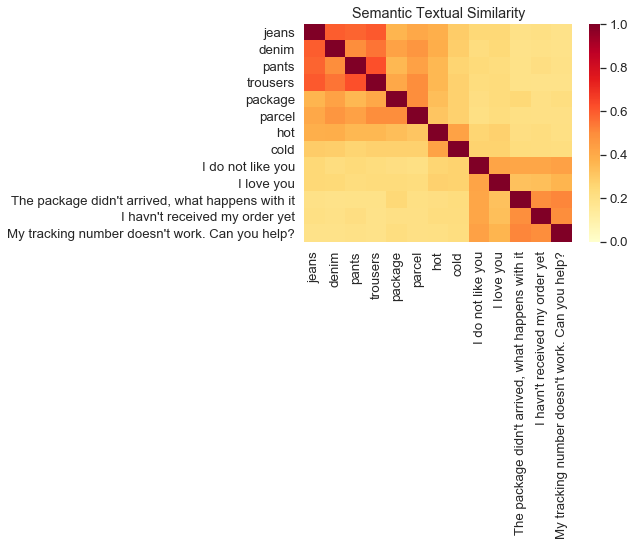

In [17]:
sim_e_c, cosine_similarities_ec = sim_exact_cross(embs, embs)
plot_similarity(messages, sim_e_c)